# Mean Variance Optimization by [@zalecodes](https://www.instagram.com/zalecodez/)

In the [last notebook](https://github.com/zalecodez/Stock-Portfolio-Optimization/blob/master/SharpeRatioOptimization.ipynb), I wrote a Portfolio Optimiser that maximized the Sharpe Ratio of a portfolio. 

In this notebook, I'll explore portfolio optimization some more, pointing out shortcomings of the sharpe ratio optimization and explore a more flexible method - Mean Variance Optimization.

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as spo
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from classes.portfolio import Portfolio
%load_ext autoreload
%aimport classes.portfolio
%autoreload 1

### The Portfolio
So if you haven't, check out the previous notebook which introduces this portfolio and the Sharpe Ratio Optimizer. 
I've modified the portfolio a bit by adding a stock - XOM.
So the new portfolio is:

Starting Value $1M
- SPY - 40%
- GOOG - 10%
- GLD - 10%
- IBM - 20%
- XOM - 20%


In [3]:
assets = ['SPY','GOOG','GLD','IBM','XOM']
alloc = [0.4, 0.1, 0.1, 0.2, 0.2]
start_val = 1000000
start_date = '2015-01-01'
end_date = '2017-12-31'

p = Portfolio(start_val, assets, alloc, start_date, end_date)

## Sharpe Ratio Optimizer
So I've encapsulated the methods from the previous notebook in a Portfolio class. 

Below shows the comparison between the portfolio above and the portfolio after being optimized based on the Sharpe ratio. 

/Users/zale/ease/analysis/portfolioOpt/classes/portfolio.py:86: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if alloc == None:
/Users/zale/ease/analysis/portfolioOpt/classes/portfolio.py:65: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if alloc == None:
/Users/zale/ease/analysis/portfolioOpt/classes/portfolio.py:58: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if alloc == None:


Symbols: ['SPY', 'GOOG', 'GLD', 'IBM', 'XOM']
[0.4, 0.1, 0.1, 0.2, 0.2]: Old Allocation
New Allocation: [ 0.39  0.32  0.3   0.    0.  ]


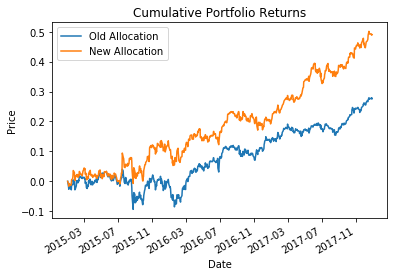

Old Avg Daily Return: 0.000349831430342
Old Return for entire 3 year period: 0.275945626053
Old Sharpe Ratio:  0.0479558516617 

New Avg Daily Return: 0.000555238503869
New Return for entire 3 year period: 0.49022934839
New Sharpe Ratio:  0.0768252854022


In [4]:
opt = p.sharpe_optimize()
Portfolio.compare(p,opt)

### Discussion

Recall that the sharpe ratio is a sort of risk adjusted return. The return is measured by the average daily return of the portfolio. The risk is measured by the standard deviation of the daily returns. 

It is important to note that even though the optimized portfolio does much better than the portfolio we had before, as shown above, it is NOT the portfolio with the highest return. To see what I'm talking about, check out this portfolio:
- SPY - 30%
- GOOG - 40%
- GLD - 10%
- IBM - 10%
- XOM - 10%

Below, we see that this portfolio (blue) cops higher returns than the optimized portfolio (orange).

Symbols: ['SPY', 'GOOG', 'GLD', 'IBM', 'XOM']
[0.3, 0.4, 0.1, 0.1, 0.1]: Old Allocation
New Allocation: [ 0.39  0.32  0.3   0.    0.  ]


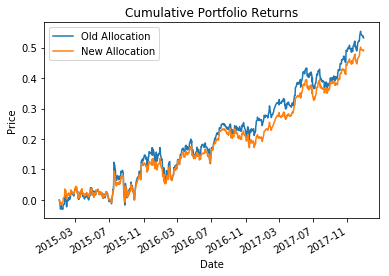

Old Avg Daily Return: 0.000604625466225
Old Return for entire 3 year period: 0.531924188148
Old Sharpe Ratio:  0.0684700886616 

New Avg Daily Return: 0.000555238503869
New Return for entire 3 year period: 0.49022934839
New Sharpe Ratio:  0.0768252854022


In [5]:
test = Portfolio(start_val, assets, [0.3,0.4,0.1,0.1, 0.1], start_date, end_date)
Portfolio.compare(test,opt)

And to see an even more extreme example, if we want the portfolio with the highest returns possible, all we have to do is choose the stock with the highest cumulative returns (GOOG):
- SPY - 0%
- GOOG - 100%
- GLD - 0%
- IBM - 0%
- XOM - 0%

Symbols: ['SPY', 'GOOG', 'GLD', 'IBM', 'XOM']
[0.0, 1.0, 0.0, 0.0, 0.0]: Old Allocation
New Allocation: [ 0.39  0.32  0.3   0.    0.  ]


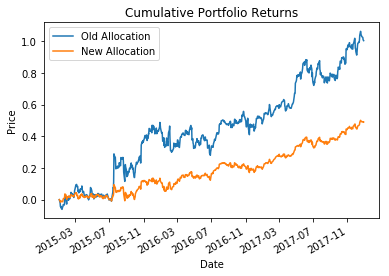

Old Avg Daily Return: 0.00102076060028
Old Return for entire 3 year period: 1.00483685273
Old Sharpe Ratio:  0.0722339666596 

New Avg Daily Return: 0.000555238503869
New Return for entire 3 year period: 0.49022934839
New Sharpe Ratio:  0.0768252854022


In [6]:
goog = Portfolio(start_val, assets, [0.,1.,0.,0.,0.], start_date, end_date)
Portfolio.compare(goog, opt)

Sharpe Ratio Optimization doesn't claim to find the portfolio with the most returns. As we've seen, if we want that, we'd just choose the single stock with the highest returns. What the Sharpe Ratio Optimizer does is tries to find the best tradeoff between return and risk. 

But what if we want to control that tradeoff? What if we want a certain target return and the lowest risk for that target? This is where Mean Variance Optimization comes in.

Before we start the discussion, let's create some useful dataframes.

In [7]:
df = p.df

daily_ret = (df/df.shift(1) - 1)[1:]
avg = daily_ret.mean()
std = daily_ret.std()

cum_ret = df/df.iloc[0] - 1

ibm = df['IBM']
goog = df['GOOG']
spy = df['SPY']
gld = df['GLD']
xom = df['XOM']

ibm_daily = daily_ret['IBM']
goog_daily = daily_ret['GOOG']
spy_daily = daily_ret['SPY']
gld_daily = daily_ret['GLD']
xom_daily = daily_ret['XOM']

### Returns vs Risk 

Let's take a look at where each asset in the portfolio sits in the graph of returns vs risk.

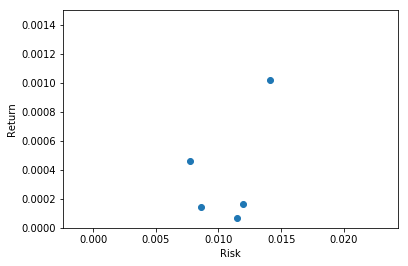

In [8]:
plt.scatter(std, avg)
#plt.scatter(p.std_daily_ret,p.avg_daily_ret)
#plt.yscale('log')
plt.ylim(0, 1.5e-3)
plt.ylabel("Return")
plt.xlabel("Risk")
plt.show()

Notice that topmost point represents the GOOG asset, with the highest return but also the highest risk.

Consider the graph below:

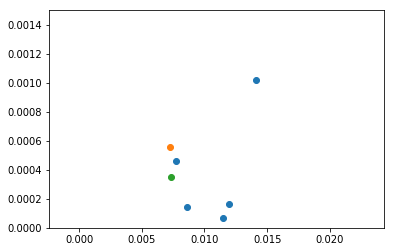

In [9]:
plt.scatter(std, avg)
plt.scatter(opt.std_daily_ret,opt.avg_daily_ret)
plt.scatter(p.std_daily_ret,p.avg_daily_ret)
plt.ylim(0, 1.5e-3)
plt.show()

The green point represents the original portfolio. The orange point represents the optimized portoflio. Notice that the original portfolio has roughly the same risk level (very slightly higher) as the optimized portfolio. So the optimization realized that we can get a portfolio with the same risk level, but higher returns. 

Another thing to take note of is that the portfolios actually have a lower risk than any given asset within the portfolio. This is interesting because that implies that it is possible to take high-risk assets to form a low risk portfolio. How is this possible? To understand that, we must understand covariance. 

## Covariance
Covariance is basically the relationship between two variables. 

Formula for Covariance:
$$
Cov(x,y) = \frac{\sum_{i=1}^n (x_i-\mu_x)(y_i-\mu_y)}{n}
$$

Note:
- When $x_i$ is below it's mean, then $x_i-\mu_x$ is negative. 
- When $x_i$ is above it's mean, then $x_i-\mu_x$ is positive. 
- Same for $y_i$
- When both $x_i$ and $y_i$ are below their means, the product $(x_i-\mu_x)(y_i-\mu_y)$ is positive 
- When both $x_i$ and $y_i$ are above their means, the product is positive
- When one is above it's mean and one is below it's mean, the product is negative

So basically: 
- If $y$ is usually high when $x$ is high, and low when $x$ is low, then a positive covariance exists.
- If $y$ is usually high when $x$ is low, and low when $x$ is high, then a negative covariance exists.
- If there is no such trend, then the covariance is close to 0.


So now let's write a function to calculate covariance, then let's look at some examples of the covariance between the daily returns of different pairs of stocks. 

In [10]:
def cov(x,y):
    meanx = x.mean
    meany = y.mean
    
    return ((x-x.mean())*(y-y.mean())).mean()

#### Example 1
SPY and GOOG:

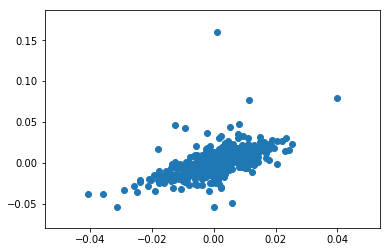

Covariance: 6.31994742376e-05


In [11]:
plt.scatter(spy_daily,goog_daily)
plt.show()
print("Covariance:",cov(spy_daily,goog_daily))

This pair of stocks has a slight positive covariance.

#### Example 2
GLD and GOOG:

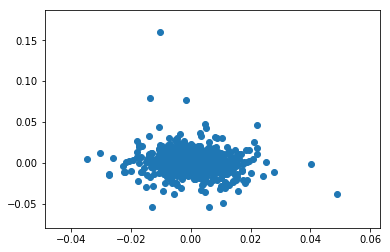

Covariance: -1.36215291218e-05


In [12]:
plt.scatter(gld_daily, goog_daily)
plt.show()
print("Covariance:",cov(gld_daily,goog_daily))

This pair has an even slighter negative covariance.

Below shows the covariance matrix of all assets in the portfolio:

In [13]:
cov_matrix = pd.DataFrame(index=assets, columns=assets)

for x in assets:
    for y in assets:
        x_daily = daily_ret[x]
        y_daily = daily_ret[y]
        cov_matrix[x][y] = cov(x_daily,y_daily)

cov_matrix

,SPY,GOOG,GLD,IBM,XOM
SPY,6.01868e-05,6.31995e-05,-1.3125e-05,5.68819e-05,5.62606e-05
GOOG,6.31995e-05,0.000199429,-1.36215e-05,5.7198e-05,3.95882e-05
GLD,-1.3125e-05,-1.36215e-05,7.38101e-05,-1.25014e-05,-5.08916e-06
IBM,5.68819e-05,5.7198e-05,-1.25014e-05,0.000143706,6.09772e-05
XOM,5.62606e-05,3.95882e-05,-5.08916e-06,6.09772e-05,0.000131922


## Why is Covariance Important?

Okay, I know what you're thinking. What in the world does covariance have to do with portfolio risk?

Well... recall that risk/volatility is often measured by the standard deviation daily returns. Also, recall that variance is the square of standard deviation. So it is not hard to imagine that if variance measure's volatility of a single stock, then the volatility of a group of stocks (portfolio) has some relationship with the covariance among the stocks within the portfolio. 

To get a more intuitive understanding of this, let's examine three fictitious stocks:

Stock 1 Risk/Volatility (Standard Deviation): 0.0172401340546


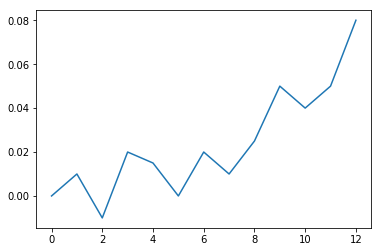


Stock 2 Risk/Volatility (Standard Deviation): 0.0198130148023


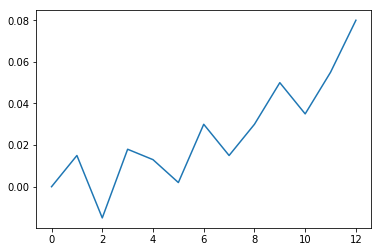


Stock 3 Risk/Volatility (Standard Deviation): 0.0258015934047


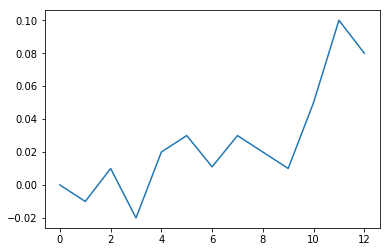


All Three Stocks:


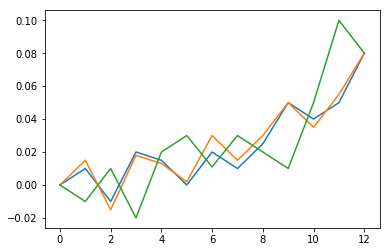

In [14]:
stock1 = np.array([0,0.01,-0.01,0.02,0.015,0,0.02,0.01,0.025,0.05,0.04,0.05,0.08])
stock2 = np.array([0,0.015,-0.015,0.018,0.013,0.002,0.03,0.015,0.03,0.05,0.035,0.055,0.08])
stock3 = np.array([0,-0.01,0.01,-0.02,0.02,0.03,0.011,0.03,0.02,0.01,0.05,0.1,0.08])

stock1_daily = stock1[1:]-stock1[:-1]
stock2_daily = stock2[1:]-stock2[:-1]
stock3_daily = stock3[1:]-stock3[:-1]

print("Stock 1 Risk/Volatility (Standard Deviation):",stock1_daily.std())
plt.plot(stock1)
plt.show()
print("\nStock 2 Risk/Volatility (Standard Deviation):",stock2_daily.std())
plt.plot(stock2)
plt.show()
print("\nStock 3 Risk/Volatility (Standard Deviation):",stock3_daily.std())
plt.plot(stock3)
plt.show()

print("\nAll Three Stocks:")
plt.plot(stock1)
plt.plot(stock2)
plt.plot(stock3)
plt.show()

Each of these stocks have the same cumulative return at the end of the period but they have different daily returns leading up to that. Also, each stock is rather volatile, so how can we create a portfolio of these stocks that has the same return but is less volatile than all three individual stocks?

First, let's consider a portfolio of 50% stock1, 50% stock2, 0% stock3

Covariance between Stock1 and Stock2: 0.000327638888889


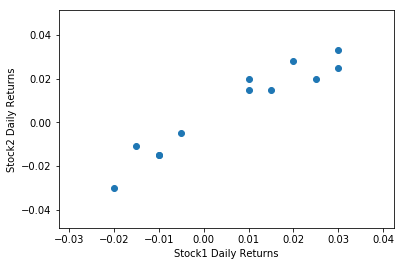



Portfolio (red) of 50% Stock1, 50% Stock2, 0% Stock3

Portfolio Risk/Volatility (Standard Deviation): 0.0183374995266


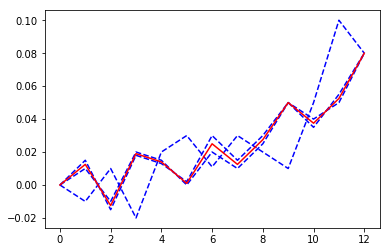

In [15]:
print("Covariance between Stock1 and Stock2:",cov(stock1_daily, stock2_daily))
plt.scatter(stock1_daily, stock2_daily)
plt.xlabel("Stock1 Daily Returns")
plt.ylabel("Stock2 Daily Returns")
plt.show()

folio = stock1*0.5 + stock2*0.5
folio_daily = folio[1:]-folio[:-1]
print("\n\nPortfolio (red) of 50% Stock1, 50% Stock2, 0% Stock3")
print("\nPortfolio Risk/Volatility (Standard Deviation):",folio_daily.std())
plt.plot(stock1,linestyle='--',c='b')
plt.plot(stock2,linestyle='--',c='b')
plt.plot(stock3,linestyle='--',c='b')
plt.plot(folio,linestyle='-',c='r')
plt.show()
print()

We see that Stock1 and Stock2 have a very strong positive covariance. Because of this, a portfolio with just these two stocks will have roughly the same level of volatility as those stocks, shown above. 

Now let's bring Stock3 into the mix. Consider the covariance between Stock1 and Stock3 (the covariance between stock2 and stock3 will be similar since stock1 and stock2 are so similar).

Covariance between Stock1 and Stock3: -0.000312777777778


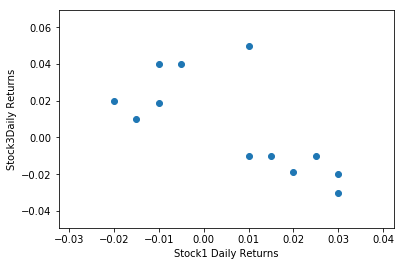

In [16]:
print("Covariance between Stock1 and Stock3:",cov(stock1_daily, stock3_daily))
plt.scatter(stock1_daily, stock3_daily)
plt.xlabel("Stock1 Daily Returns")
plt.ylabel("Stock3Daily Returns")
plt.show()

We see that these stocks have a negative covariance. They're anti-correlated. 

So let us now create a portfolio of 25% Stock1, 25% Stock2, 50% Stock3. 

Portfolio (red) of 25% Stock1, 25% Stock2, 50% Stock3

Portfolio Risk/Volatility (Standard Deviation): 0.00959618703213


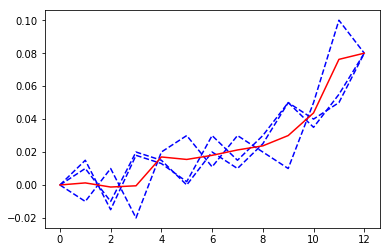

In [17]:
folio = stock1*0.25 + stock2*0.25 + stock3*0.5
folio_daily = folio[1:]-folio[:-1]
print("Portfolio (red) of 25% Stock1, 25% Stock2, 50% Stock3")
print("\nPortfolio Risk/Volatility (Standard Deviation):",folio_daily.std())
plt.plot(stock1,linestyle='--',c='b')
plt.plot(stock2,linestyle='--',c='b')
plt.plot(stock3,linestyle='--',c='b')
plt.plot(folio,linestyle='-',c='r')

Boom! 

By grouping stocks with a positive covariance and mixing them with an equal amount of stocks that have a negative covariance to those in that group, we create a portfolio that has a lower volatility than the individual assets. This is significant. 

Okay so now back to mean variance optimization.

## Mean Variance Optimization

The idea is that we are able to set a target average daily return and achieve a portfolio with the minimum risk for that return. 

#### The algorithm:
```
def mvo_optimize(self,target):
    def evaluate(X):
        _,_,std_daily_ret = self.calc_daily_ret(X)
        return std_daily_ret 

    def meet_target(X):
        _, avg_daily_ret, _ = self.calc_daily_ret(X)
        return avg_daily_ret - target

    self.best = spo.minimize(evaluate, [1/len(self.alloc)]*len(self.alloc), 
                method='SLSQP', 
                bounds=[(0.0,1.0)]*len(self.alloc), 
                constraints=[{'type':'eq', 'fun': lambda x: x.sum() - 1},
                             {'type':'eq', 'fun': meet_target}])

    return Portfolio(self.start_val, self.assets.copy(), self.best.x.copy(), self.start, self.end)
```

#### Example

/Users/zale/ease/analysis/portfolioOpt/classes/portfolio.py:65: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if alloc == None:
/Users/zale/ease/analysis/portfolioOpt/classes/portfolio.py:58: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if alloc == None:


Symbols: ['SPY', 'GOOG', 'GLD', 'IBM', 'XOM']
[0.4, 0.1, 0.1, 0.2, 0.2]: Old Allocation
New Allocation: [ 0.48  0.12  0.4   0.    0.  ]


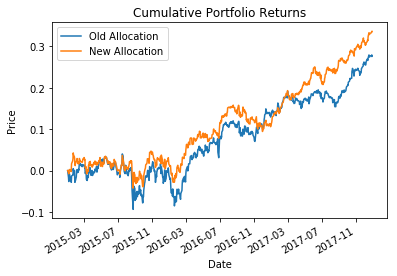

Old Avg Daily Return: 0.000349831430342
Old Return for entire 3 year period: 0.275945626053
Old Sharpe Ratio:  0.0479558516617 

New Avg Daily Return: 0.000400016173338
New Return for entire 3 year period: 0.336293328179
New Sharpe Ratio:  0.0718984747531


In [18]:
o1 = p.mvo_optimize(0.0004)
Portfolio.compare(p,o1)

This gives us much more control over the portfolio. Recall the Sharpe Ratio Optimized Portfolio (Orange):

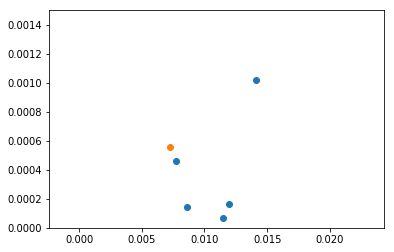

In [19]:
plt.scatter(std, avg)
plt.scatter(opt.std_daily_ret,opt.avg_daily_ret)
plt.ylim(0, 1.5e-3)
plt.show()

The average daily return for this portfolio is a bit less than 0.0006

What if we wanted slightly higher daily returns... Say about 0.0007. Mean Variance Optimization gives us this control:

/Users/zale/ease/analysis/portfolioOpt/classes/portfolio.py:65: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if alloc == None:
/Users/zale/ease/analysis/portfolioOpt/classes/portfolio.py:58: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if alloc == None:


Symbols: ['SPY', 'GOOG', 'GLD', 'IBM', 'XOM']
[  3.85443773e-01   3.17020635e-01   2.97535592e-01   7.48099499e-17
   5.37764278e-17]: Sharpe Ratio Optimized
Mean Variance Optimized(0.0007): [ 0.28  0.52  0.21  0.    0.  ]


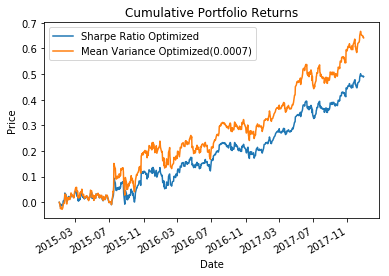

Old Avg Daily Return: 0.000555238503869
Old Return for entire 3 year period: 0.49022934839
Old Sharpe Ratio:  0.0768252854022 

New Avg Daily Return: 0.000700033710762
New Return for entire 3 year period: 0.641460012214
New Sharpe Ratio:  0.0755769079913


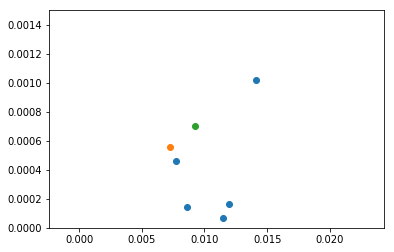

In [20]:
o = p.mvo_optimize(0.0007)
Portfolio.compare(opt,o, old="Sharpe Ratio Optimized",new="Mean Variance Optimized(0.0007)")

plt.scatter(std, avg)
plt.scatter(opt.std_daily_ret,opt.avg_daily_ret)
plt.scatter(o.std_daily_ret,o.avg_daily_ret)

plt.ylim(0, 1.5e-3)
plt.show()

## The Efficient Frontier
Mean Variance Optimization allows us to find the optimal portfolio at any given level of return. In other words, for any given target return, we can construct a portfolio with the minimum possible risk level. 

This allows us to create a curve made up of all these minumum-risk portfolios. This is called the Efficient Frontier. Any given point on the curve represents the portfolio with the minimum risk for that return level. Let's take a look.

In [21]:
ys = np.linspace(avg.min(), avg.max(), num=80)

f =  np.vectorize(p.mvo_optimize)

xs = f(ys)

/Users/zale/ease/analysis/portfolioOpt/classes/portfolio.py:65: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if alloc == None:
/Users/zale/ease/analysis/portfolioOpt/classes/portfolio.py:58: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if alloc == None:


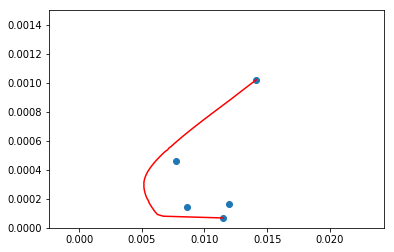

In [22]:
plt.scatter(std, avg)
#plt.yscale('log')
plt.ylim(0, 1.5e-3)

plt.plot([x.std_daily_ret for x in xs], ys,c='r')
plt.show()

The red curve represents the Efficient Frontier.

Note:
- Any Portfolio which falls to the right of the curve is a sub-optimal portfolio. It would either be too high a risk for that return, or too low a return for that level of risk. 
- It is impossible to create a portfolio (with these assets) to the left of the curve.

Let's take a look at where our optimized portfolios fall:

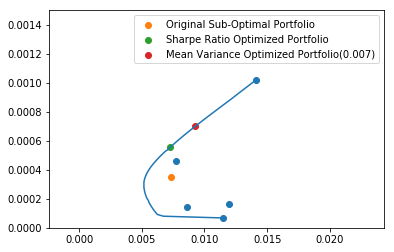

In [23]:
plt.scatter(std, avg)
plt.scatter(p.std_daily_ret,p.avg_daily_ret, label='Original Sub-Optimal Portfolio')
plt.scatter(opt.std_daily_ret,opt.avg_daily_ret, label='Sharpe Ratio Optimized Portfolio')
plt.scatter(o.std_daily_ret,o.avg_daily_ret, label='Mean Variance Optimized Portfolio(0.007)')

plt.legend()
#plt.yscale('log')
plt.ylim(0, 1.5e-3)

plt.plot([x.std_daily_ret for x in xs], ys)#[x.avg_daily_ret for x in xs])
plt.show()

Notice how the optimized portfolios fall on the curve and the sub-optimal portfolio, as well as the individual stocks fall to the left of the curve. The assets with the lowest and highest returns, however, fall on the curve, at the extremes. This is because the portfolio with the highest return is 100% the stock with the highest return and the portfolio with the lowest return is 100% the stock with the lowest return. Therefore those extreme portfolios must assume the risk of the extreme assets. 

Another improtant thing to note is that, if we draw a tangent to the curve from the origin, the point at which it meets the cureve is the Sharpe Ratio Optimized Portfolio:

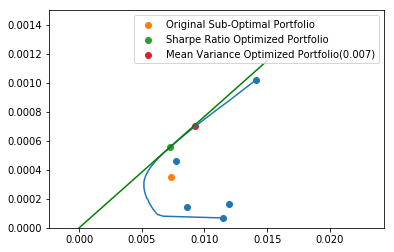

In [24]:
plt.scatter(std, avg)
plt.scatter(p.std_daily_ret,p.avg_daily_ret, label='Original Sub-Optimal Portfolio')
plt.scatter(opt.std_daily_ret,opt.avg_daily_ret, label='Sharpe Ratio Optimized Portfolio')
plt.scatter(o.std_daily_ret,o.avg_daily_ret, label='Mean Variance Optimized Portfolio(0.007)')

plt.legend()
#plt.yscale('log')
plt.ylim(0, 1.5e-3)

plt.plot([x.std_daily_ret for x in xs], ys)#[x.avg_daily_ret for x in xs])
m = opt.sharpe
x = np.linspace(0., 0.015, num=5)
y = x*m
plt.plot(x,y,c='g')
plt.show()

## Conclusions
- Sharpe Ratio Optimized Portfolio doesn't give the portfolio with the highest return. It give the best risk-adjusted reutrn


- It is possible to construct a low-risk portfolio from high-risk assets by considering the covariance between assets. Having an equal mix of correlated and anticorrelated assets allows for this. 


- Mean Variance Optimization allows us to find the portfolio with the lowest risk for a given target return.


- The efficient frontier is the curve upon which all optimal portfolios lie. To the right of it are suboptimal portfolios. To the left of it are non-existent portfolios (for the given assets)

#### Remember the Caveat
It is important to note that these are "hindsight" evaluations. We used past performance of a portfolio to determine which allocation would have been the optimal. This is not to say that this portfolio is optimal for the future. Past performance does not indicate future performance. 

Or does it?